# Black box optimization for RL
> Notes on various approaches to black box optimization used in RL

- branch: 2020-05-12-black-box-optimization
- badges: true
- image: images/???
- comments: true
- author: David R. Pugh
- categories: [pytorch, deep-reinforcement-learning, optimization]

### Google Colab Preamble

If you are playing around with this notebook on Google Colab, then you will need to run the following cell in order to install the required OpenAI dependencies into the environment.

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


The code in the cell below creates a virtual display in the background that your Gym Envs can connect to for rendering. You can adjust the size of the virtual buffer as you like but you must set `visible=False`.

**This code only needs to be run once per session to start the display.**

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

### Binder Preamble

If you are running this code on Binder, then there isn't really much to do as all the software is pre-installed. However you do still need to run the code in the cell below to creates a virtual display in the background that your Gym Envs can connect to for rendering. You can adjust the size of the virtual buffer as you like but you must set `visible=False`.

*This code only needs to be run once per session to start the display.*

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

# Black-box optimization

Black-box optimization is great for proto-typing, or for situations when the objective function is not differentiable.

## Base RL Agent

The code in the cell below defines a base `Agent` class designed to interact with [OpenAI Gym](https://gym.openai.com/) environments. When creating an `Agent` you must specify a `PolicyFn`. A `PolicyFn` is a no-argument function that returns a `Policy`. A `Policy` is a function that takes the environment state is its input and then returns the probabilities of choosing feasible actions. Here I use neural networks implemented in [PyTorch](https://pytorch.org/) as [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) to represent a `Policy`. 

can also specify whether the agent should use a deterministic or stochastic policy for choosing actions. With a stochastic policy (which is the default), the agent samples from the probability distribution returned by its current approximate policy function when choosing its action given the state of the environment. With a deterministic policy, meanwhile, the agent always chooses the action with the largest probability mass. 

In [1]:
import typing

import numpy as np
import torch
from torch import distributions, nn


GymState = np.ndarray
Policy = nn.Module
PolicyFn = typing.Callable[[], Policy]
PreprocessingFn = typing.Callable[[GymState], torch.Tensor] 
Action = int


class GymAgent:
    
    def __init__(self,
                 policy_fn: PolicyFn,
                 gamma: float = 1.0,
                 is_deterministic: bool = False,
                 preprocessing_fn: typing.Optional[PreprocessingFn] = None,
                 seed: typing.Optional[int] = None):
        if torch.cuda.is_available():
            self._device = torch.device("cuda") 
        else:
            self._device = torch.device("cpu")
        self._gamma = gamma
        self._is_deterministic = is_deterministic
        self._policy = policy_fn()
        _ = self._policy.to(self._device)
        
        # converts np.ndarray with shape (n_states,) to torch.Tensor with shape (1, n_states)
        if preprocessing_fn is None:
            self._preprocessing_fn = lambda state: torch.Tensor(state).unsqueeze(dim=0) 
        else:
            self._preprocessing_fn = preprocessing_fn
            
        if seed is None:
            self._random_state = np.random.RandomState()
        else:
            self._random_state = np.random.RandomState(seed)
            torch.manual_seed(seed)
            
            # if using CUDA need to set cuDNN flags
            #if torch.cuda.is_available():
            #    torch.backends.cudnn.deterministic = True
            #    torch.backends.cudnn.benchmark = False
        
    def __call__(self, state: GymState) -> Action:
        """Apply the current policy function to the state and returns the action."""
        state_tensor = (self._preprocessing_fn(state)
                            .to(self._device))
        sampling_probs = (self._policy(state_tensor)
                              .cpu())
        if self._is_deterministic:
            action = (sampling_probs.argmax()
                                    .item())
        else:
            sampling_dist = distributions.Categorical(sampling_probs)
            action = (sampling_dist.sample()
                                   .item())
        return action

    def evaluate(self, rewards) -> None:
        """Evaluate rewards generated from following the current policy while interacting with an environment."""
        raise NotImplementedError
        
    def load_state_dict(self, state_dict: typing.Dict[str, torch.Tensor]) -> None:
        """Update the parameters of the policy function using the state_dict."""
        copied_state_dict = copy.deepcopy(state_dict) # avoid sharing mutable state_dict!
        _ = self._policy.load_state_dict(copied_state_dict)
        

## Training Loop

In [11]:
import collections

import gym


Score = int


def _train_for_at_most(agent: GymAgent, env: gym.Env, max_timesteps: int) -> Score:
    """Train the Agent for a maximum number of timesteps."""
    state = env.reset()
    rewards = []
    for t in range(max_timesteps):
        action = agent(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        rewards.append(reward)
        if done:
            break
    return sum(rewards), rewards

                
def _train_until_done(agent: GymAgent, env: gym.Env) -> Score:
    """Train the Agent until the current episode is complete."""
    state = env.reset()
    rewards = []
    done = False
    while not done:
        action = agent(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        rewards.append(reward)
    return sum(rewards), rewards


def train(agent: GymAgent,
          env: gym.Env,
          target_score: Score,
          maximum_episodes: int,
          maximum_timesteps: typing.Optional[int] = None,
          verbose: bool = False) -> typing.List[Score]:
    """Train and Agent to solve a given environment."""
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(maximum_episodes):
        if maximum_timesteps is None:
            score, rewards = _train_until_done(agent, env)
        else:
            score, rewards = _train_for_at_most(agent, env, maximum_timesteps)         
        scores.append(score)
        most_recent_scores.append(score)
        agent.evaluate(rewards)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if len(most_recent_scores) >=100 and average_score >= target_score:
            if verbose:
                print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            break
        if verbose and (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores


In [3]:
import matplotlib.pyplot as plt
from IPython import display


def simulate(agent: GymAgent, env: gym.Env, ax: plt.Axes) -> None:
    state = env.reset()
    img = ax.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = agent(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)       
    env.close()

# CartPole environment

The [CartPole](https://gym.openai.com/envs/CartPole-v0/) is a classic RL problem. A pole is attached by an un-actuated joint to a cart which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pole starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In the cell below I define a function that takes the number of actions and number of states as inputs and returns a `PolicyFn`. In this case the defined policy amounts to performing logistic regression. The policy takes a state vector as its input and predicts the probabilities of moving left or right. Note that I do not include a bias term: if the state vector is the zero vector, then our policy should be to neither move left nor right.

# Algorithms

## Hill-climbing

A [Hill-climbing algorithm](https://en.wikipedia.org/wiki/Hill_climbing) is a mathematical optimization technique. It is an iterative algorithm that starts with an arbitrary (typically random) solution to a problem, then attempts to find a better solution by making an incremental change to the existing solution. If the change produces a better solution, another incremental change is made to the new solution, and so on until no further improvements can be found.

The code in the cell below defines a `HillClimber` agent that uses a neural network to parameterize an approximate policy function which return the probability of choosing each of a discrete number of actions given the current state of its environment. The agent will keep track of the "best" policy function parameters as measured by the total (discounted) rewards achieved from following that policy while intereacting with its environment. During an iteration of the training algorithm the agent randomly updates the current "best" parameters and then uses the resulting policy function to interact with its environment and generate more rewards. If the performance of the agent improves, then the agent updates its "best" parameters accordingly; if the agent's performance degrades, then the agent resets the current parameters to their previous "best" values.

In [4]:
import copy


class HillClimber(GymAgent):
    
    def __init__(self,
                 policy_fn: PolicyFn,
                 gamma: float = 1.0,
                 is_deterministic: bool = False,
                 preprocessing_fn: typing.Optional[PreprocessingFn] = None,
                 seed: typing.Optional[int] = None,
                 sigma: float = 1.0):
        super().__init__(policy_fn, gamma, is_deterministic, preprocessing_fn, seed)
        self._max_discounted_reward = -float("inf")
        copied_state_dict = copy.deepcopy(self._policy.state_dict()) # avoid storing mutable state!
        self._best_policy_state_dict = copied_state_dict 
        self._sigma = sigma
        
    def __ge__(self, other):
        return not self.__lt__(other)
    
    def __lt__(self, other):
        return self._max_discounted_reward < other._max_discounted_reward

    @property
    def best_policy_state_dict(self):
        """The state_dict parameterizing the best policy function found thus far."""
        return self._best_policy_state_dict
    
    @property
    def score(self):
        """The maximum discounted reward achieved thus far."""
        return self._max_discounted_reward
    
    def evaluate(self, rewards):
        """Evaluate rewards generated from following the current policy when interacting with an environment."""
        discounted_reward = sum(self._gamma**i * reward for i, reward in enumerate(rewards))
        if discounted_reward >= self._max_discounted_reward:
            self._max_discounted_reward = discounted_reward
            copied_state_dict = copy.deepcopy(self._policy.state_dict()) # avoid storing mutable state!
            self._best_policy_state_dict = copied_state_dict           
        else:
            _ = self.load_state_dict(self._best_policy_state_dict)
        with torch.no_grad():
            for parameter in self._policy.parameters():
                parameter.add_(torch.randn_like(parameter), alpha=self._sigma)


## Performance of an untrained `HillClimber`

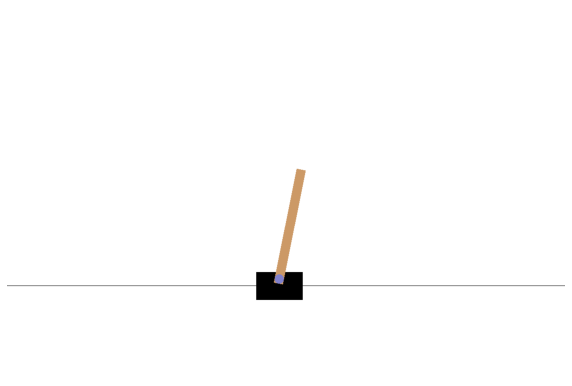

In [10]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
simulate(hillclimber, env, ax)

## Performance of a trained `Hillclimber`

In [5]:
def make_policy_fn(number_actions, number_states) -> PolicyFn:
    
    def policy_fn() -> Policy:
        policy = nn.Sequential(
            nn.Linear(number_states, number_actions, bias=False),
            nn.Softmax(dim=-1)
        )
        return policy
    
    return policy_fn


In [ ]:
NUMBER_ACTIONS = env.action_space.n
NUMBER_STATES, = env.observation_space.shape

In [21]:
%%time
_seed = 42
env = gym.make('CartPole-v0')
env.seed(_seed)

_policy_fn = make_policy_fn(NUMBER_ACTIONS, NUMBER_STATES)
hillclimber = HillClimber(policy_fn=_policy_fn, seed=_seed)
scores = train(hillclimber, env, target_score=195.0, maximum_episodes=1000, verbose=True)

Episode 100	Average Score: 151.17
Episode 200	Average Score: 145.24
Episode 300	Average Score: 165.94
Episode 400	Average Score: 169.29
Episode 500	Average Score: 180.09

Environment solved in 526 episodes!	Average Score: 195.39
CPU times: user 10.1 s, sys: 30 ms, total: 10.1 s
Wall time: 10.1 s


The `Hillclimber` requires almost 700 episodes of training to solve the environment. Seems slow but perhaps this training run is not representative of the typical performance of the algorithm. The following code simulates  

In [29]:
%%time
import joblib
import multiprocessing


env = gym.make('CartPole-v0')

hillclimber_kwargs = {
    "policy_fn": make_policy_fn(NUMBER_ACTIONS, NUMBER_STATES),
    "gamma": 1.0,
    "is_deterministic": False,
    "preprocessing_fn": None,
    "seed": None,
    "sigma": 1.0
}


def simulate_hillclimber():
    hillclimber = HillClimber(**hillclimber_kwargs)
    scores = train(hillclimber, env, target_score=195.0, maximum_episodes=1000)
    return scores


n_jobs = multiprocessing.cpu_count()
n_hillclimbers = 100
hillclimber_results = joblib.Parallel(n_jobs)(joblib.delayed(simulate_hillclimber)() for _ in range(n_hillclimbers))    

CPU times: user 1.16 s, sys: 68.9 ms, total: 1.23 s
Wall time: 3min 2s


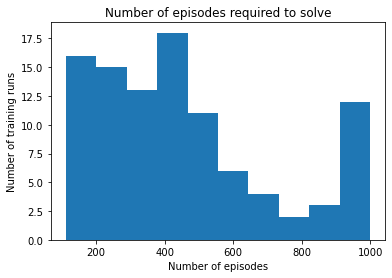

In [36]:
fig, ax = plt.subplots(1, 1)

hillclimber_required_episodes = [len(scores) for scores in hillclimber_results]
_ = ax.hist(hillclimber_required_episodes)
_ = ax.set(xlabel="Number of episodes",
           ylabel="Number of training runs",
           title="Number of episodes required to solve")

## Improving hill-climing using adaptive noise scaling

As you can see from the above histogram, a basic hill-climbing algorithm is not terribly robust: basic hill-climbing often takes a long time to solve the environment and sometimes outright fails to find a solution even after 1000 episodes.

Many improvements to the basic hill-climbing algorithm have been developed over the years. One simple improvement called adaptive noise scaling rescales the noise in the parameter updates depending on the performance of the `Hillclimber` agent. If the `HillClimber` agent's previous random parameter update improved its performance, then the amount of noise used in the next parameter update is decreased (leading to less local exploration of the objective function); if the `HillClimber` agent's performance degraded following the previous random update, then the amount of noise used in the next parameter update is increased (leading to more local exporation of the objective function).

In [37]:
import copy


class AdaptiveHillClimber(HillClimber):
    
    def __init__(self,
                 policy_fn: PolicyFn,
                 gamma: float = 1.0,
                 is_deterministic: bool = False,
                 preprocessing_fn: typing.Optional[PreprocessingFn] = None,
                 seed: typing.Optional[int] = None,
                 sigma: float = 1.0):
        super().__init__(policy_fn, gamma, is_deterministic, preprocessing_fn, seed, sigma)
        self._best_policy_state_dict = self._policy.state_dict()
    
    def evaluate(self, rewards):
        """Evaluate rewards generated from following the current policy when interacting with an environment."""
        discounted_reward = sum(self._gamma**i * reward for i, reward in enumerate(rewards))
        if discounted_reward >= self._max_discounted_reward:
            self._max_discounted_reward = discounted_reward
            copied_state_dict = copy.deepcopy(self._policy.state_dict()) # avoid storing mutable state!
            self._best_policy_state_dict = copied_state_dict
            self._sigma = max(2**-10, self._sigma / 2)
        else:
            self._sigma = min(2, self._sigma * 2)
            _ = self.load_state_dict(self._best_policy_state_dict)
        with torch.no_grad():
            for parameter in self._policy.parameters():
                parameter.add_(torch.randn_like(parameter), alpha=self._sigma)


In [39]:
%%time

_seed = None
env = gym.make('CartPole-v0')
env.seed(_seed)

hillclimber = AdaptiveHillClimber(policy_fn=_policy_fn, seed=_seed)
scores = train(hillclimber, env, target_score=195.0, maximum_episodes=1000, verbose=True)

Episode 100	Average Score: 53.39
Episode 200	Average Score: 161.00

Environment solved in 233 episodes!	Average Score: 195.31
CPU times: user 3.32 s, sys: 10.7 ms, total: 3.33 s
Wall time: 3.34 s


To see the impact of adaptive noise scaling, we can re-run the simulation above.

In [40]:
%%time

env = gym.make('CartPole-v0')

hillclimber_kwargs = {
    "policy_fn": make_policy_fn(NUMBER_ACTIONS, NUMBER_STATES),
    "gamma": 1.0,
    "is_deterministic": False,
    "preprocessing_fn": None,
    "seed": None,
    "sigma": 1.0
}


def simulate_hillclimber():
    hillclimber = AdaptiveHillClimber(**hillclimber_kwargs)
    scores = train(hillclimber, env, target_score=195.0, maximum_episodes=1000)
    return scores


n_jobs = multiprocessing.cpu_count()
n_hillclimbers = 100
hillclimber_results = joblib.Parallel(n_jobs)(joblib.delayed(simulate_hillclimber)() for _ in range(n_hillclimbers))    

CPU times: user 1.25 s, sys: 15.9 ms, total: 1.27 s
Wall time: 1min 54s


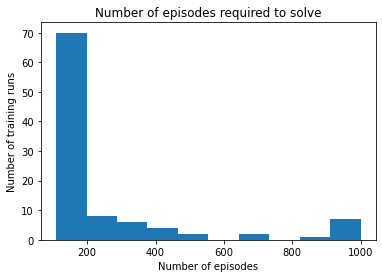

In [41]:
fig, ax = plt.subplots(1, 1)
adaptive_hillclimber_required_episodes = [len(scores) for scores in hillclimber_results]
_ = ax.hist(adaptive_hillclimber_required_episodes)
_ = ax.set(xlabel="Number of episodes",
           ylabel="Number of training runs",
           title="Number of episodes required to solve")

## Steepest Ascent Hill-climbing

Steepest ascent hill-climbing is an extension of the basic hill-climbing algorithm that is more robust. Rather than using a single `HillClimber`, the steepest ascent algorithm starts with a population of `HillClimber` instances. During an iteration of the steepest ascent algorithm each of the `HillClimber` instances is trained using the basic algorithm and then the `HillClimber` that has made the most progress is identified and the parameters of its policy function are shared with the other `HillClimber` instances. This processes is repeated until either the environment is solved or some maximum number of iteration is reached.

In [146]:
HillClimbers = typing.List[HillClimber]


def synchronize_hillclimbers(hillclimbers: HillClimbers,
                             state_dict: typing.Dict[str, torch.Tensor]) -> None:
    _ = [hillclimber.load_state_dict(state_dict) for hillclimber in hillclimbers]


def top_k_hillclimbers(hillclimbers: HillClimbers, k: int = 1) -> HillClimbers:
    sorted_hillclimbers = sorted(hillclimbers)
    return sorted_hillclimbers[-k:]


In [45]:
def steepest_ascent_hillclimbing(env: gym.Env,
                                 hillclimber_kwargs: dict,
                                 target_score: float,
                                 number_episodes: int = 2,
                                 number_hillclimbers: int = 5,
                                 number_iterations: int = 150,
                                 verbose: bool = False):
    hillclimbers = [HillClimber(**hillclimber_kwargs) for _ in range(number_hillclimbers)]
    scores = []
    most_recent_scores = collections.deque(maxlen=100)

    n_jobs = multiprocessing.cpu_count()
    
    for i in range(number_iterations):
        # train each hillclimber for some number of episodes (this can be done in parallel)
        _ = joblib.Parallel(n_jobs)(joblib.delayed(train)(_, env, float("inf"), number_episodes) for _ in hillclimbers)    

        # identify the best hillclimber and evaluate the best policy
        best_hillclimber, = top_k_hillclimbers(hillclimbers)
        score = best_hillclimber.score
        scores.append(score)
        most_recent_scores.append(score)
        
        # if not solved, then synchronize the hill climbers and repeat
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if len(most_recent_scores) >= 100 and average_score >= target_score:
            if verbose:
                print(f"\nEnvironment solved in {i:d} iterations!\tAverage Score: {average_score:.2f}")
            break
        else:
            synchronize_hillclimbers(hillclimbers, best_hillclimber._best_policy_state_dict)
    
    return scores, best_hillclimber

In [47]:
_policy_fn = make_policy_fn(NUMBER_ACTIONS, NUMBER_STATES)

_hillclimber_kwargs = {
    "policy_fn": _policy_fn,
    "gamma": 1.0,
    "is_deterministic": False,
    "preprocessing_fn": None,
    "seed": None,
    "sigma": 1.0
}

env = gym.make('CartPole-v0')

scores, best_hillclimber = steepest_ascent_hillclimbing(env, _hillclimber_kwargs, target_score=195.0, verbose=True)

/Users/drpugh/Research/stochastic-expatriate-descent/env/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [150]:
_seed = None
env = gym.make('CartPole-v0')
env.seed(_seed)

_policy_fn = make_policy_fn(NUMBER_ACTIONS, NUMBER_STATES)

_hillclimber_kwargs = {
    "policy_fn": _policy_fn,
    "gamma": 1.0,
    "is_deterministic": False,
    "preprocessing_fn": None,
    "seed": None,
    "sigma": 1.0
}

steepest_ascent_required_episodes = []
for t in range(100):
    scores, _ = steepest_ascent_hillclimbing(env, _hillclimber_kwargs, target_score=195.0, number_iterations=1000)
    steepest_ascent_required_episodes.append(len(scores))


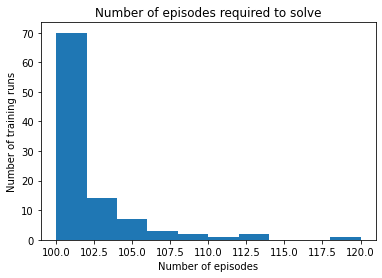

In [156]:
fig, ax = plt.subplots(1, 1)
_ = ax.hist(steepest_ascent_required_episodes)
_ = ax.set(xlabel="Number of episodes",
           ylabel="Number of training runs",
           title="Number of episodes required to solve")

## Cross Entropy Methods

While steepest ascent hill-climbing is a significant improvement over the basic hill-climbing algorithm, steepest ascent throws away quite a lot of useful information by only keep track of the parameters of the "best" `HillClimber` policy function. Instead of throwing away the parameters of the other `HillClimber` agents, what if you keep track of the policy function parameters of the top-$k$ performing `HillClimber` agents. You could then average together the values of these $k$ sets of policy function parameters to produce an estimate of the "best" policy function parameters. Repeat as necessary until the environment is solved or you have reached a maximum desired number of iterations. This is the basic idea behind [cross-entropy methods](https://en.wikipedia.org/wiki/Cross-entropy_method). 

In [161]:
def average_state_dicts(hillclimbers: typing.List[HillClimber]) -> typing.Dict[str, torch.Tensor]:
    _folded_state_dicts = collections.defaultdict(lambda: [])
    for hillclimber in hillclimbers:
        for k, v in hillclimber._best_policy_state_dict.items():
            _folded_state_dicts[k].append(v)
    averaged_state_dict = {k: torch.stack(v, dim=0).mean(dim=0) for k, v in _folded_state_dicts.items()}
    return averaged_state_dict


def cross_entropy_method(env: gym.Env,
                         hillclimber_kwargs: dict,
                         target_score: float,
                         k: int = 1,
                         number_episodes: int = 2,
                         number_hillclimbers: int = 5,
                         number_iterations: int = 150,
                         verbose: bool = False):
    hillclimbers = [HillClimber(**hillclimber_kwargs) for _ in range(number_hillclimbers)]
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    
    for i in range(number_iterations):
        # train each hillclimber for some number of episodes (this can be done in parallel!)
        _ = [train(hillclimber, env, float("inf"), number_episodes, verbose=verbose) for hillclimber in hillclimbers]
        
        # identify the best hillclimbers
        best_hillclimbers = top_k_hillclimbers(hillclimbers, k)
        
        # average the policies of the best hillclimbers to get the best overall policy
        best_policy_state_dict = average_state_dicts(best_hillclimbers)
        
        # evaluate the best overall policy
        best_hillclimber = HillClimber(**hillclimber_kwargs)
        _ = best_hillclimber.load_state_dict(best_policy_state_dict)
        score, = train(best_hillclimber, env, float("inf"), 1)
        scores.append(score)
        most_recent_scores.append(score)
        
        # if not solved, then synchronize the hill climbers and repeat
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if len(most_recent_scores) >= 100 and average_score >= target_score:
            if verbose:
                print(f"\nEnvironment solved in {i:d} iterations!\tAverage Score: {average_score:.2f}")
            break
        else:
            synchronize_hillclimbers(hillclimbers, best_policy_state_dict)
    
    return scores, best_hillclimber


The cross-entropy algorithm with `k=1` reduces to steepest ascent algorithm.

In [169]:
_seed = None
env = gym.make('CartPole-v0')
env.seed(_seed)

_policy_fn = make_policy_fn(NUMBER_ACTIONS, NUMBER_STATES)

_hillclimber_kwargs = {
    "policy_fn": _policy_fn,
    "gamma": 1.0,
    "is_deterministic": False,
    "preprocessing_fn": None,
    "seed": _seed,
    "sigma": 1.0
}

scores, best_hillclimber = cross_entropy_method(env, _hillclimber_kwargs, target_score=195.0, k=1, verbose=True)


Environment solved in 125 iterations!	Average Score: 195.44


In [174]:
_seed = None
env = gym.make('CartPole-v0')
env.seed(_seed)

_policy_fn = make_policy_fn(NUMBER_ACTIONS, NUMBER_STATES)

_hillclimber_kwargs = {
    "policy_fn": _policy_fn,
    "gamma": 1.0,
    "is_deterministic": False,
    "preprocessing_fn": None,
    "seed": _seed,
    "sigma": 1.0
}

scores, best_hillclimber = cross_entropy_method(env, _hillclimber_kwargs, target_score=195.0, k=3, number_hillclimbers=10, verbose=True)


Environment solved in 139 iterations!	Average Score: 195.48


In [173]:
_seed = None
env = gym.make('CartPole-v0')
env.seed(_seed)

_policy_fn = make_policy_fn(NUMBER_ACTIONS, NUMBER_STATES)

_hillclimber_kwargs = {
    "policy_fn": _policy_fn,
    "gamma": 1.0,
    "is_deterministic": False,
    "preprocessing_fn": None,
    "seed": None,
    "sigma": 1.0
}

cross_entropy_required_episodes = []
for t in range(100):
    scores, _ = cross_entropy_method(env, _hillclimber_kwargs, target_score=195.0, k=10, number_hillclimbers=100, number_iterations=1000)
    cross_entropy_required_episodes.append(len(scores))


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(1, 1)
_ = ax.hist(cross_entropy_required_episodes)
_ = ax.set(xlabel="Number of episodes",
           ylabel="Number of training runs",
           title="Number of episodes required to solve")

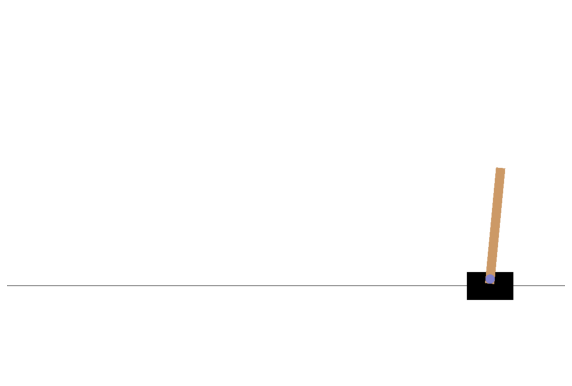

In [65]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
simulate(best_hillclimber, env, ax)

## Evolutionary strategies

OpenAI [blog post](https://openai.com/blog/evolution-strategies/) on evolutionary strategies. Link to paper https://arxiv.org/abs/1703.03864, https://arxiv.org/pdf/1703.03864.pdf

In [ ]:
def evolutionary_strategies(env: gym.Env,
                            hillclimber_kwargs: dict,
                            target_score: float,
                            k: int = 1,
                            number_episodes: int = 2,
                            number_hillclimbers: int = 5,
                            number_iterations: int = 150,
                            verbose: bool = False):
    hillclimbers = [HillClimber(**hillclimber_kwargs) for _ in range(number_hillclimbers)]
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    
    for i in range(number_iterations):
        # train each hillclimber for some number of episodes
        _ = [train(hillclimber, env, float("inf"), number_episodes, verbose=verbose) for hillclimber in hillclimbers]
        
        current_scores = torch.Tensor([hillclimber.score for hillclimber in hillclimbers])
        weights = current_scores / current_scores.sum() 
        
        # identify the best hillclimbers
        best_hillclimbers = top_k_hillclimbers(hillclimbers, k)
        
        # average the policies of the best hillclimbers to get the best overall policy
        best_policy_state_dict = average_state_dicts(best_hillclimbers)
        
        # evaluate the best overall policy
        best_hillclimber = HillClimber(**hillclimber_kwargs)
        _ = best_hillclimber.load_state_dict(best_policy_state_dict)
        score, = train(best_hillclimber, env, float("inf"), 1)
        scores.append(score)
        most_recent_scores.append(score)
        
        # if not solved, then synchronize the hill climbers and repeat
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if len(most_recent_scores) >= 100 and average_score >= target_score:
            if verbose:
                print(f"\nEnvironment solved in {i:d} iterations!\tAverage Score: {average_score:.2f}")
            break
        else:
            synchronize_hillclimbers(hillclimbers, best_policy_state_dict)
    
    return scores, best_hillclimber
